In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from Bio.Seq import Seq
import re
from Bio import pairwise2

/home/adri/.virtualenvs/bias/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [2]:
os.chdir("/home/adri/Projects/phd/bias_2")

In [3]:
def get_conservation_df(basename):   
    
    # Load alignment dataframe
    alignment_df = pd.read_csv(f"data/raw/{basename}_gpcr_alignment.csv", index_col=0, header=1)
    
    # Extract the alignment of the cb2
    cb2_alignment = alignment_df.loc['[Human] CB2 receptor'].values
    
    # Extract the sequence without gaps
    alignment_cb2_seq = ''.join([res for res in cb2_alignment if res not in  ['_', '-']])
    
    # Get the sequence from uniprot
    uniprot_cb2_sequence = 'MEECWVTEIANGSKDGLDSNPMKDYMILSGPQKTAVAVLCTLLGLLSALENVAVLYLILSSH'\
    'QLRRKPSYLFIGSLAGADFLASVVFACSFVNFHVFHGVDSKAVFLLKIGSVTMTFTASVGSLLLTAIDRYLCLRYPPSYKALLTRGRAL'\
    'VTLGIMWVLSALVSYLPLMGWTCCPRPCSELFPLIPNDYLLSWLLFIAFLFSGIIYTYGHVLWKAHQHVASLSGHQDRQVPGMARMRLD'\
    'VRLAKTLGLVLAVLLICWFPVLALMAHSLATTLSDQVKKAFAFCSMLCLINSMVNPVIYALRSGEIRSSAHHCLAHWKKCVRGLGSEAK'\
    'EEAPRSSVTETEADGKITPWPDSRDLDLSDC'
    
    seq1 = Seq(alignment_cb2_seq) 
    seq2 = Seq(uniprot_cb2_sequence)
    alignments = pairwise2.align.globalms(seq1, seq2, 2, -1, -2, -1)
    al = alignments[0].seqA
    uni = alignments[0].seqB
    
#     print(al)
#     print(uni)
    
    equivalence = []
    for resid, (a, b) in enumerate(zip(al, uni), 1):
        if a != '-':
            equivalence.append(resid)
#     print(equivalence)
    # Loading conservation scores
    conservation_scores = []

    with open(f"data/raw/{basename}_conservation_scores.txt") as file:
        for line in file:
            if re.match('\d', line):
                conservation_scores.append(float(line.split('\t')[1]))
                
    res_mask = [True if not char in ['_', '-'] else False for char in cb2_alignment]
    conservation_scores = np.array(conservation_scores)[res_mask]
    order_resid_df = []
    for resid, score in zip(equivalence, conservation_scores):  
        order_resid_df.append([score, resid])

    order_resid_df = pd.DataFrame(order_resid_df, columns=[f'{basename}_score', 'resid'])
    order_resid_df = order_resid_df.dropna()
    
    return order_resid_df

In [4]:
class_a_conservation_df = get_conservation_df('class_a')
class_a_conservation_df

,class_a_score,resid
0,0.04546,29
1,0.04888,30
2,0.06530,31
3,0.05891,32
4,0.07116,33
...,...,...
251,0.12506,315
252,0.09567,316
253,0.07678,317
254,0.05014,318


In [5]:
expresion_data = pd.read_csv("data/raw/alanin_scanning-cuantitative_values-emax_ec50.csv")

expresion_data = expresion_data.dropna()

# filtering out WT and non alanine mutations
expresion_data = expresion_data[[bool(re.match("\w\d*$", a)) for a in expresion_data["Mutant"]]]

expresion_data = expresion_data.set_index('Position')

expresion_data = expresion_data[["%wt expression"] +
                [col for col in expresion_data.columns if "HU210" in col and ("Gi" in col or "bArr1" in col)]]

expresion_data.index = expresion_data.index.rename("position").astype(int)

expresion_data.columns = ["expression", "emax_gi", "emax_barr1", "ec50_gi", "ec50_barr1"]

In [6]:
expresion_data

,expression,emax_gi,emax_barr1,ec50_gi,ec50_barr1
position,,,,,
1,104.277644,0.825515,1.122299,0.098706,0.385988
2,116.723038,0.615114,0.907206,0.468060,0.393758
3,121.328063,1.072523,0.826491,-0.109611,-0.361701
4,84.004864,1.203155,1.060027,-0.047019,-0.022091
5,119.051109,1.003370,1.008177,-0.119622,-0.119924
...,...,...,...,...,...
356,94.837573,1.062682,0.976102,-0.189900,0.130637
357,97.655672,1.167825,0.747814,-0.240117,0.007049
358,98.189135,1.107844,0.862811,-0.101797,0.468228


In [7]:
# merge expression and conservation data
merged_df = expresion_data.merge(class_a_conservation_df, left_index=True, right_on='resid')

In [8]:
merged_df

,expression,emax_gi,emax_barr1,ec50_gi,ec50_barr1,class_a_score,resid
0,84.827855,1.377266,1.453091,-0.080726,0.204319,0.04546,29
1,91.118165,1.057022,1.336484,-0.067825,0.075457,0.04888,30
2,90.139799,1.131454,1.090715,0.147191,-0.039388,0.06530,31
3,109.149191,1.430271,1.454057,-0.130197,0.259686,0.05891,32
4,101.781051,1.045174,0.945484,-0.112751,0.555771,0.07116,33
...,...,...,...,...,...,...,...
250,52.808938,0.000000,0.000000,9.725648,8.942628,0.18158,314
251,74.661364,1.284922,1.169000,-0.033109,0.396290,0.12506,315
252,69.933913,1.215658,1.539277,-0.287555,0.171420,0.09567,316
253,34.920211,1.364871,0.000000,-0.056020,8.942628,0.07678,317


In [9]:
merged_df = merged_df[(merged_df.emax_gi > 0) & (merged_df.emax_barr1 > 0) & (merged_df.ec50_gi < 3) & (merged_df.ec50_barr1 < 3)]

In [10]:
# add categorical variable expression levels above 120, between 80 and 120 and below 80
merged_df['expression_cat'] = pd.cut(merged_df.expression, [0, 80, 120, 1000], labels=['low', 'wt-like', 'high'])

/tmp/ipykernel_1422835/3241144043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['expression_cat'] = pd.cut(merged_df.expression, [0, 80, 120, 1000], labels=['low', 'wt-like', 'high'])


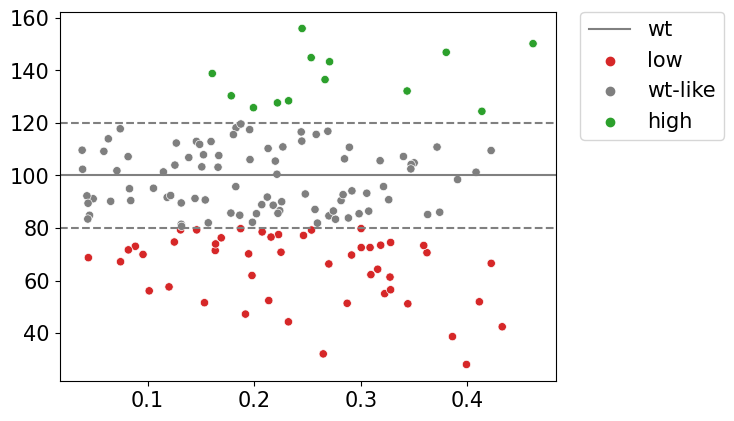

In [23]:
# use colors in positions 3, 7 and 2 of the tab10 palette
palette = sns.color_palette("tab10")
colors = [palette[3], palette[7], palette[2]]
plt.rcParams.update({'font.size': 15})

plt.axhline(100, color="grey", label='wt')
sns.scatterplot(data = merged_df, x='class_a_score', y='expression', hue='expression_cat', palette=colors)


# add dashed grey lines at 120 and 80
plt.axhline(120, color="grey", linestyle='--')
plt.axhline(80, color="grey", linestyle='--')


# plt.xlabel("Conservation (JSD)")
# plt.ylabel("Cell surface expression (%)")
# plt.title("Relation between conservation\nand cell surface expression")

plt.xlabel("")
plt.ylabel("")
# plt.title("Relation between conservation\nand cell surface expression")

# put legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figures/figure_1/conservation_vs_expression.png", dpi=300, bbox_inches='tight')

plt.show()

In [25]:
count_df = merged_df.value_counts('expression_cat', normalize=True).reset_index()
# multiply "proportion" by 100 to get percentages
count_df['proportion'] = count_df['proportion']*100

In [26]:
merged_df.value_counts('expression_cat', normalize=True).reset_index()

,expression_cat,proportion
0,wt-like,0.587838
1,low,0.324324
2,high,0.087838


In [27]:
count_df

,expression_cat,proportion
0,wt-like,58.783784
1,low,32.432432
2,high,8.783784


In [28]:
merged_df

,expression,emax_gi,emax_barr1,ec50_gi,ec50_barr1,class_a_score,resid,expression_cat
0,84.827855,1.377266,1.453091,-0.080726,0.204319,0.04546,29,wt-like
1,91.118165,1.057022,1.336484,-0.067825,0.075457,0.04888,30,wt-like
2,90.139799,1.131454,1.090715,0.147191,-0.039388,0.06530,31,wt-like
3,109.149191,1.430271,1.454057,-0.130197,0.259686,0.05891,32,wt-like
4,101.781051,1.045174,0.945484,-0.112751,0.555771,0.07116,33,wt-like
...,...,...,...,...,...,...,...,...
248,111.810435,0.982697,0.934621,0.005608,0.219769,0.14882,312,wt-like
249,103.116714,1.107911,0.718919,-0.004872,0.216116,0.16606,313,wt-like
251,74.661364,1.284922,1.169000,-0.033109,0.396290,0.12506,315,low
252,69.933913,1.215658,1.539277,-0.287555,0.171420,0.09567,316,low


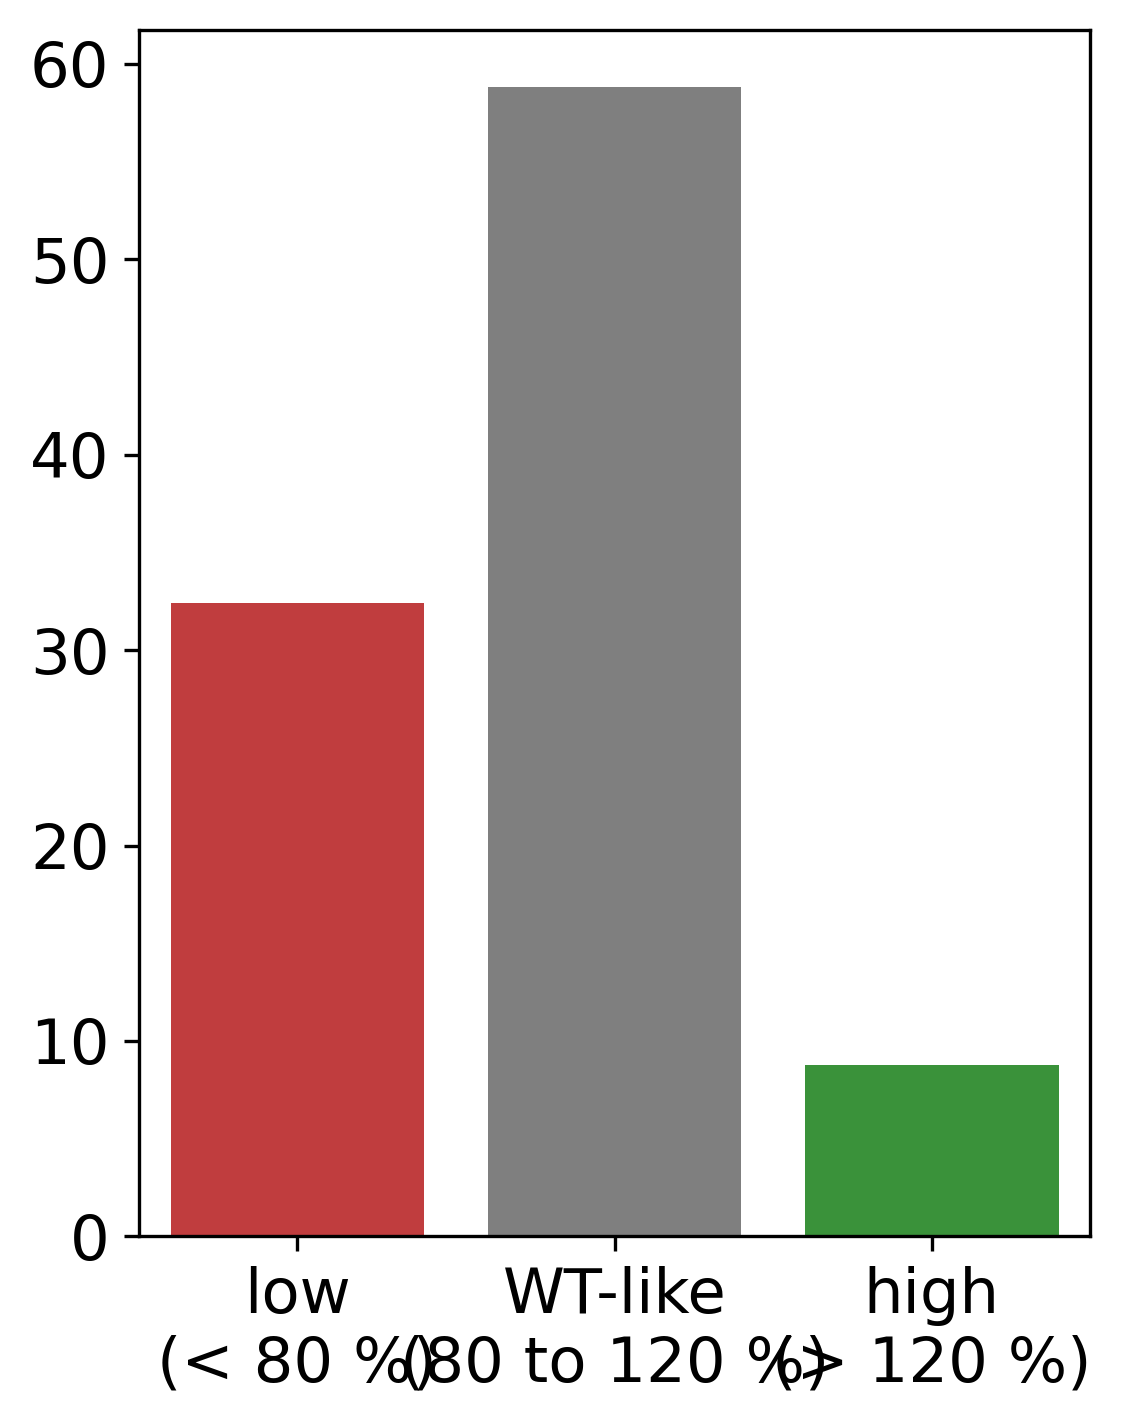

In [31]:
# plot a barplot with the percentage of the expression categories
plt.figure(figsize=(4, 5), dpi=300)

plt.rcParams.update({'font.size': 15})

sns.barplot(data = count_df, x='expression_cat', y='proportion' ,palette=colors)



# change xticks labels
plt.xticks(ticks=[0, 1, 2], labels=['low\n(< 80 %)', 'WT-like\n(80 to 120 %)', 'high\n(> 120 %)'])

plt.xlabel("")
plt.ylabel("")
# plt.title("Distribution of expression categories")
plt.tight_layout()
plt.savefig("figures/figure_1/expression_categories.png", dpi=300, bbox_inches='tight')
plt.show()
